In [7]:
from transformers import AutoTokenizer, LongformerForSequenceClassification, pipeline
import pandas as pd
import torch

In [8]:
summary = "Here is an essay about economics. It is really interesting and I like to write about economics. Economics is the best in the whole world ever."
source = "Economics is the study of money. Money is fun but also scary. /n Economics is fun!"

In [9]:
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
wording_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-wording-global', num_labels=1)
content_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-content-global', num_labels=1)

In [10]:
def inference(summary, source, model):
    combined = summary + '</s>' + source
    context = tokenizer(combined)
    sep_index = context['input_ids'].index(2)
    context['global_attention_mask'] = [1]*(sep_index + 1) + [0]*(len(context['input_ids'])-(sep_index + 1))
    inputs = {}
    for key in context:
        inputs[key] = torch.tensor([context[key]])
    return float(model(**inputs)['logits'][0][0])

In [11]:
DATA = '../data/'
summaries_df = pd.read_csv(DATA + 'final_summaries_ai_aloe_fixed.csv').drop(columns = ['Unnamed: 0','Unnamed: 0.1'])


from sklearn.preprocessing import StandardScaler
import numpy as np
  
# copy the data
df_normalized = summaries_df.copy()
  
# apply normalization techniques
df_normalized['content_pca'] = StandardScaler().fit_transform(np.array(df_normalized['content_pca']).reshape(-1,1))
df_normalized['paraphrase_pca'] = StandardScaler().fit_transform(np.array(df_normalized['paraphrase_pca']).reshape(-1,1))  


source_texts = df_normalized['source_text_filename_clean'].value_counts().to_frame().reset_index()
texts_to_remove = list(source_texts.iloc[15:31]['source_text_filename_clean'])

test_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove)]
train_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove) == False]
print('test n:', len(test_df))
print('train n:', len(train_df))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
test_df.loc[:,'content_global_pred'] = test_df.apply(lambda row: inference(row['text'], row['source'], content_model), axis=1)

In [7]:
test_df.loc[:,'wording_global_pred'] = test_df.apply(lambda row: inference(row['text'], row['source'], wording_model), axis=1)

/tmp/ipykernel_305/2113310307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'wording_global_pred'] = test_df.apply(lambda row: inference(row['text'], row['source'], wording_model), axis=1)


In [12]:
test_df['test-train'] = 'test'
train_df['test-train'] = 'train'

pd.concat([test_df, train_df]).to_csv('../results/final_summaries_scored.csv')

/tmp/ipykernel_305/4087090162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['test-train'] = 'test'
/tmp/ipykernel_305/4087090162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['test-train'] = 'train'


In [8]:
wording_pipe = pipeline('text-classification', model='tiedaar/summary-roberta-wording', function_to_apply="none", truncation=True)
content_pipe = pipeline('text-classification', model='tiedaar/summary-roberta-content', function_to_apply="none", truncation=True)

def getWordingScore(text):
    return wording_pipe(text)[0]['score']

def getContentScore(text):
    return content_pipe(text)[0]['score']


In [9]:
getWordingScore(summary)

-1.4803746938705444

In [10]:
test_df.loc[:, 'content_roberta_pred'] = test_df['text'].apply(lambda x: getContentScore(x))

/tmp/ipykernel_1294/3456795374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'content_roberta_pred'] = test_df['text'].apply(lambda x: getContentScore(x))


In [11]:
test_df.loc[:, 'wording_roberta_pred'] = test_df['text'].apply(lambda x: getWordingScore(x))

/tmp/ipykernel_1294/879213240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'wording_roberta_pred'] = test_df['text'].apply(lambda x: getWordingScore(x))


In [19]:

test_df.columns
#test_df[['content_roberta_pred', 'wording_roberta_pred', 'content_longformer_pred', 'wording_longformer_pred', 'content_pca', 'paraphrase_pca']].corr()

Index(['Row.names', 'filename', 'filename_clean', 'source_text', 'Main.Point',
       'Details', 'Cohesion', 'Objective.Language', 'Wording.Para',
       'Lang..Bey..ST', 'Summ..Length', 'content pca', 'wording pca', 'text',
       'source_text_clean', 'source_text_filename_clean', 'source',
       'longformer content', 'longformer wording', 'roberta content',
       'roberta wording'],
      dtype='object')

In [20]:
test_df.columns = ['Row.names', 'filename', 'filename_clean', 'source_text', 'Main.Point',
       'Details', 'Cohesion', 'Objective.Language', 'Wording.Para',
       'Lang..Bey..ST', 'Summ..Length', 'content pca', 'wording pca',
       'text', 'source_text_clean', 'source_text_filename_clean', 'source',
       'longformer content', 'longformer wording', 'roberta content',
       'roberta wording']

In [21]:
test_df[['content pca', 'wording pca', 'longformer content', 'longformer wording', 'roberta content','roberta wording']].corr()

,content pca,wording pca,longformer content,longformer wording,roberta content,roberta wording
content pca,1.000000,0.710421,0.907282,0.681890,0.816777,0.645847
wording pca,0.710421,1.000000,0.696000,0.836284,0.553707,0.641082
longformer content,0.907282,0.696000,1.000000,0.741664,0.868276,0.703652
longformer wording,0.681890,0.836284,0.741664,1.000000,0.633640,0.738016
roberta content,0.816777,0.553707,0.868276,0.633640,1.000000,0.758015
roberta wording,0.645847,0.641082,0.703652,0.738016,0.758015,1.000000


In [15]:
long_df = pd.melt(test_df, 
            id_vars=['Row.names','content pca','wording pca'], 
            value_vars=['roberta content', 'roberta wording', 'longformer content', 'longformer wording'],
            var_name='model',
            value_name='predicted score',
            col_level=None,
            ignore_index=True)

In [16]:
long_df

,Row.names,content pca,wording pca,model,predicted score
0,1244,-1.049251,-0.062491,roberta content,-2.101325
1,1245,-1.049251,-0.732844,roberta content,-0.217115
2,1247,-0.617744,-0.732844,roberta content,-0.761425
3,1248,-0.833497,-0.299323,roberta content,-0.279758
4,1249,-0.563806,-1.166365,roberta content,0.281571
...,...,...,...,...,...
2807,874,-0.833497,1.001242,longformer wording,0.736931
2808,901,-1.049251,0.134199,longformer wording,0.851305
2809,916,0.137393,0.724270,longformer wording,0.860641
2810,917,0.137393,0.764411,longformer wording,0.635277


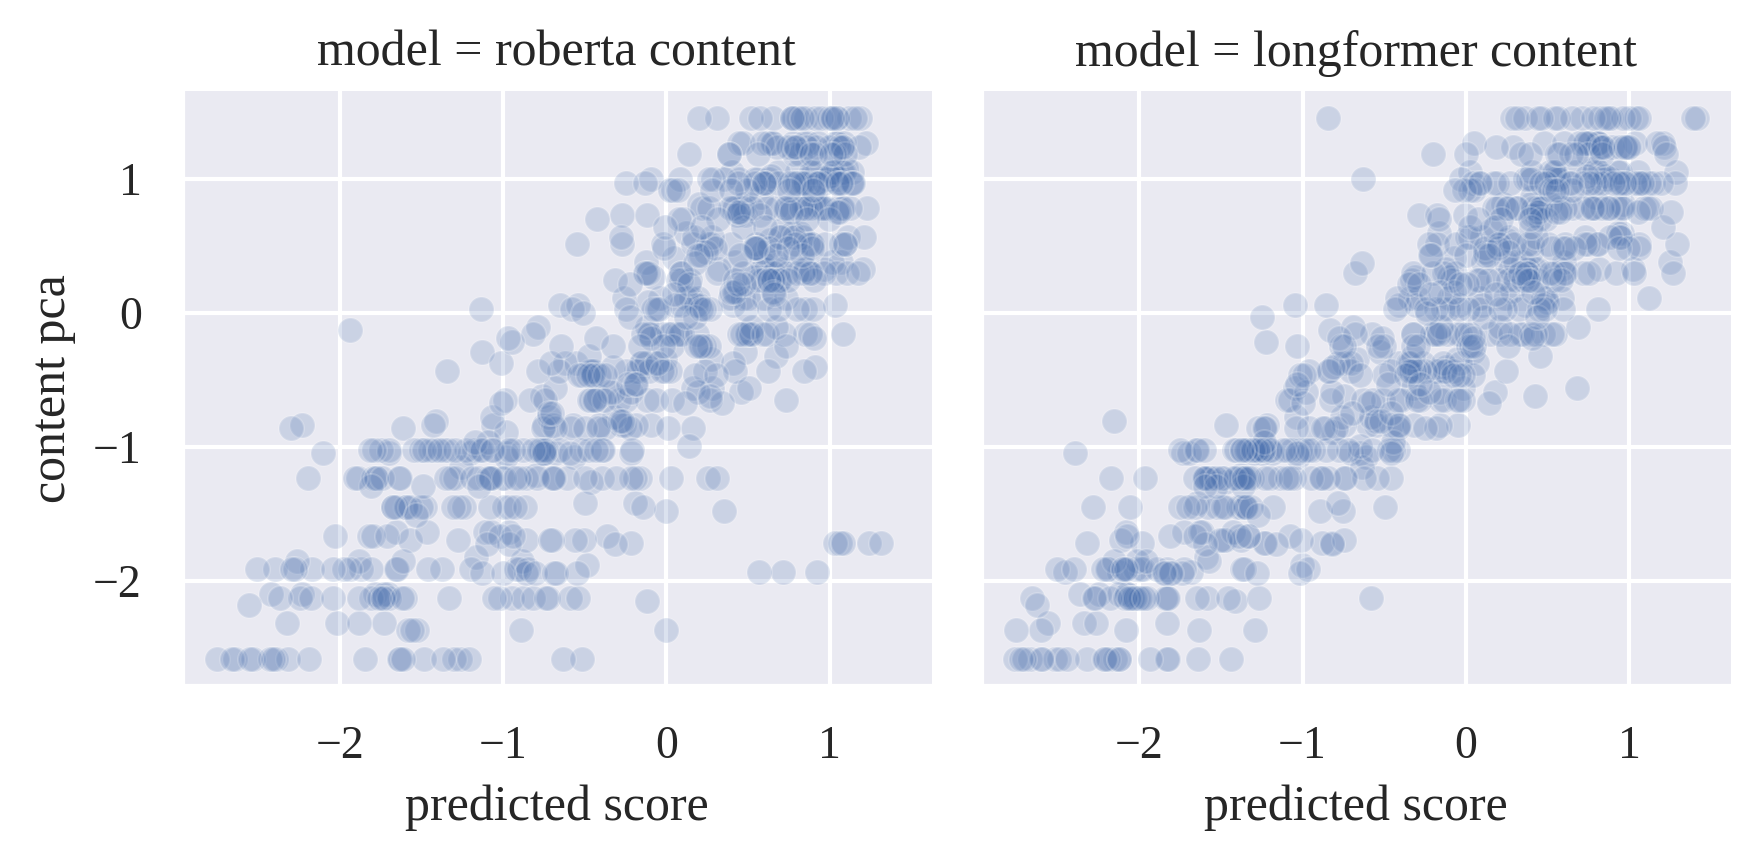

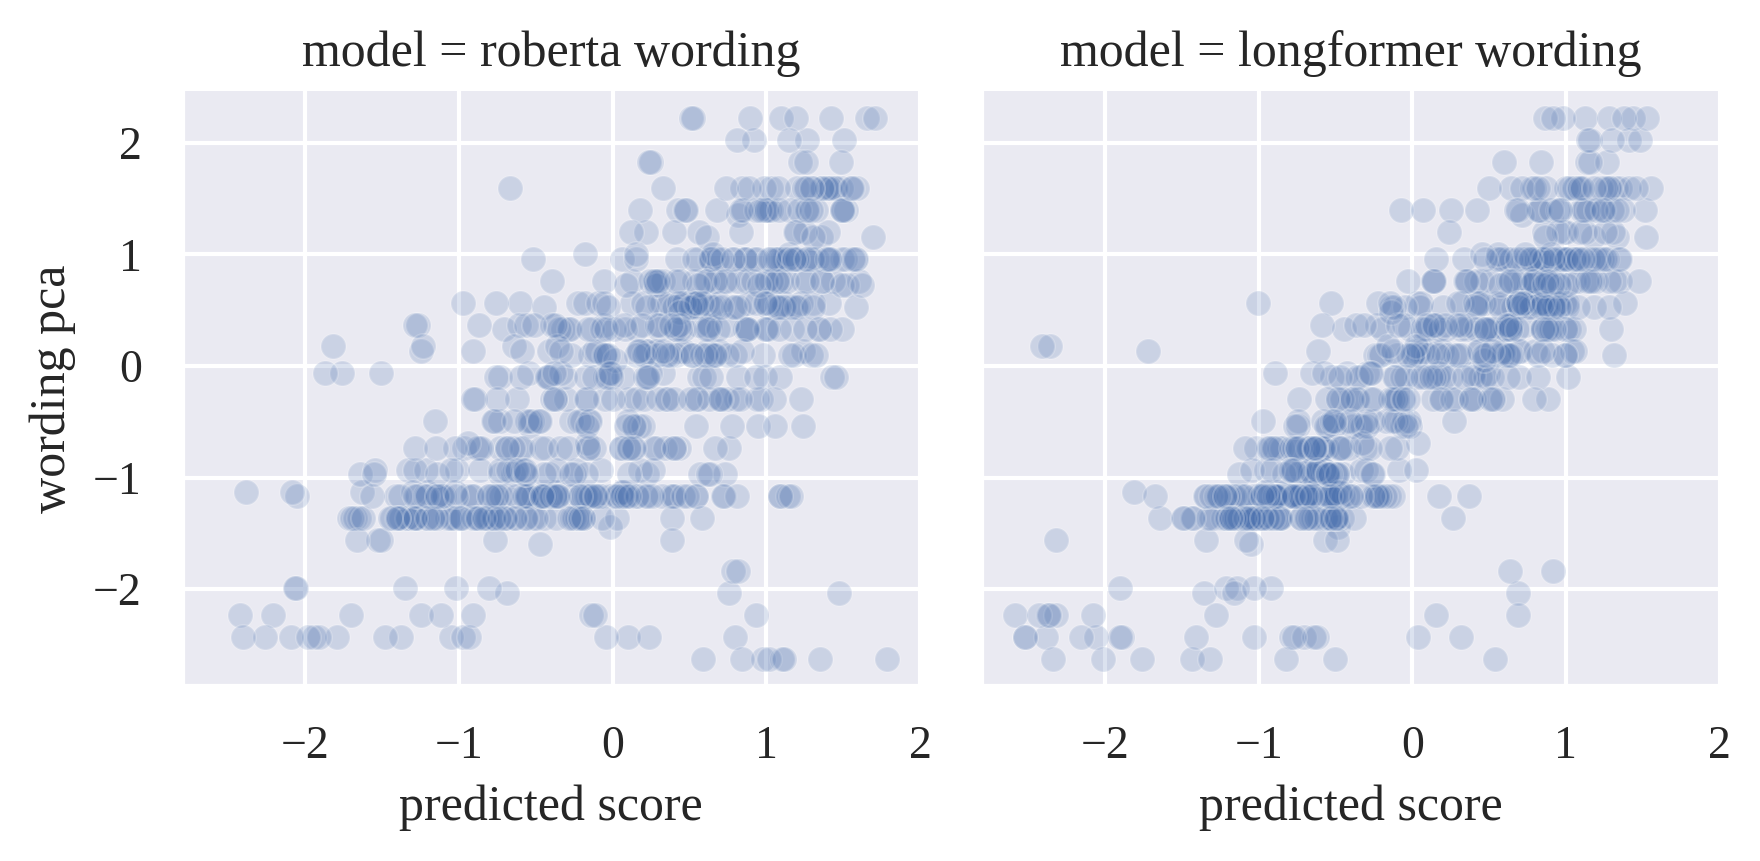

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (2,2),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

long_df['type'] = long_df['model'].apply(lambda x: x.split(' ')[1])
con_df = long_df[long_df['type'] == 'content']
wor_df = long_df[long_df['type'] == 'wording']

#define grid
g = sns.FacetGrid(data=con_df, col='model', col_wrap=2)
h = sns.FacetGrid(data=wor_df, col='model', col_wrap=2)
#add plots to grid
g.map(sns.scatterplot, 'predicted score', 'content pca', alpha = 0.2)
h.map(sns.scatterplot, 'predicted score', 'wording pca', alpha = 0.2)

In [18]:
sns.scatterplot(wor_df[wor_df['model']=='type'], p)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 sns.scatterplot(wor_df[wor_df['model']=='type'], p)                                          │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'p' is not defined

In [ ]:
sns.scatterplot(con_df[con_df['model']=='roberta content'], x='predicted score', y='wording pca')